# Understanding Movies Using LSA

In [1]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

% matplotlib inline

## Loading the Data

I've left the data in single files for each year, so that an enthusiastic person of the future could add extra years' data easily.

In [2]:
dfs = []
for year in range(1940, 2018):
    dfs.append(pd.read_csv('scraped_movies/top_movies_of_%d.csv' % year, encoding = 'cp1252'))
movie_data = pd.concat(dfs)

In [3]:
dfs = []
for year in range(1940, 2018):
    dfs.append(pd.read_csv('scraped_movies/keywords_for_top_movies_of_%d.csv' % year, encoding = 'cp1252'))
keywords = pd.concat(dfs)

In [4]:
movie_data.index = range(len(movie_data))
keywords.index = range(len(keywords))

In [5]:
movie_data.head()

,IMDbId,IMDb_score,box_office_rank,genre_list,release_year,title
0,tt0032910,7.5,1.0,"Animation, Comedy, Family",1940,Pinocchio (1940)
1,tt0032455,7.8,2.0,"Animation, Family, Fantasy",1940,Fantasia (1940)
2,tt0032384,6.8,3.0,Drama,1940,De Mayerling à Sarajevo (1940)
3,tt0032976,8.2,4.0,"Drama, Mystery, Romance",1940,Rebecca (1940)
4,tt0032553,8.5,5.0,"Comedy, Drama, War",1940,The Great Dictator (1940)


In [6]:
keywords.head()

,IMDbId,keywords
0,tt0032910,italy|pinocchio|jiminy-cricket|puppet|conscien...
1,tt0032455,classical-music|disney|mouse|orchestra|apprent...
2,tt0032384,NaN
3,tt0032976,bride|widower|estate|monte-carlo|housekeeper|w...
4,tt0032553,invented-language|dual-role|fictitious-country...


We can see there's some movies missing keywords, and probably a bunch of missing data elsewhere too. I'm basically ignoring that at the moment.

## Lookup objects

For convenience, I'm defining here a bunch of lookups I'll later use to filter the datasets - they're mostly boolean series, or dicts.

In [7]:
marvel_lookup = keywords.keywords.fillna('').str.contains('marvel-cinematic-universe')

In [8]:
title_lookup = pd.Series(movie_data.title)
title_lookup.index = movie_data.IMDbId
title_lookup = title_lookup.to_dict()




In [9]:
furiouses = ['The Fast and the Furious (2001)',
'2 Fast 2 Furious (2003)',
'The Fast and the Furious: Tokyo Drift (2006)',
'Fast & Furious (2009)',
'Fast Five (2011)',
'Furious 6 (2013)',
'Furious Seven (2015)',
'The Fate of the Furious (2017)']

furious_lookup = keywords.IMDbId.map(title_lookup).isin(furiouses)

In [10]:
princess_lookup = keywords.keywords.fillna('').str.contains('disney-princess')

In [11]:
jaws_lookup = keywords.IMDbId.map(title_lookup).apply(lambda x: 'jaws' in x.lower())

In [12]:


decade_lookup = pd.DataFrame(movie_data.release_year.apply(lambda x: math.floor(x/10)*10))
decade_lookup.index = movie_data.IMDbId
decade_lookup = decade_lookup.to_dict()['release_year']

In [13]:
chocula = CountVectorizer(tokenizer = lambda x: x.split(', '))
genres = chocula.fit_transform(movie_data.genre_list.fillna('xxx')).toarray()
genre_lookup = pd.DataFrame(genres, columns = chocula.get_feature_names())
genre_lookup.index = movie_data.IMDbId

In [14]:
rank_lookup = pd.Series(movie_data.box_office_rank)
rank_lookup.index = movie_data.IMDbId
rank_lookup = rank_lookup.to_dict()


## Process Example

I'm running through the whole transformation with a sample of the data, to demonstrate what it looks like at each stage.

We're transforming our list of movies and keywords into a list of movies and a set of columns storing an abstract numeric represenation of that movie, derived from its similarity to other movies, in terms of their shared keywords. The steps are:

- "Bag of words" encoding - making a table with a column for each keyword
- "TFIDF" weighting - weighting each movie's keyword entries to account for movies with more or fewer total keywords
- Taking the "Dot Product" - Creating a matrix comparing each movie to each other movie, in terms of keyword similarity.
- Applying "Dimensionality Reduction" - reducing the number of columns in the matrix from one per movie to a smaller number of abstract values.

In [15]:
sample = keywords[(keywords.IMDbId.map(rank_lookup) < 10)& # Make sure they're movies someone has heard of
                  (keywords.IMDbId.map(title_lookup).apply(len) < 25)  # Make sure the title's aren't too long to display nicely
                 ].sample(10)

pd.DataFrame([sample.IMDbId.map(title_lookup), 
              sample.keywords.apply(lambda x: ', '.join(str(x).split('|')))]).transpose()

,IMDbId,keywords
6900,Avatar (2009),"paraplegic, avatar, marine, native, future, ec..."
5405,Dumb and Dumber (1994),"friendship, character-says-i-love-you, referen..."
6008,Scary Movie (2000),"suntan-pantyhose, pantyhose, foot-closeup, fem..."
7400,American Sniper (2014),"assassin, sniper, iraq, violence, iraq-war, de..."
4700,3 Men and a Baby (1987),"changing-a-baby's-diaper, baby-left-on-doorste..."
3007,Woodstock (1970),"drugs, hippie, woodstock, music-festival, the-..."
2400,Mary Poppins (1964),"nanny, female-protagonist, live-action-and-ani..."
6801,Iron Man (2008),"playboy, billionaire, inventor, afghanistan, u..."
5706,Good Will Hunting (1997),"professor, genius, friend, janitor, loss-of-wi..."
1501,Mister Roberts (1955),"u.s.-navy, naval-officer, shore-leave, south-p..."


### Bag of Words

Creating a "Countvectoriser" object, and a "TfidifTransformer", which will do bag-of-words encoding and TFIDF weighting, respectively.

In [16]:
vlad = CountVectorizer(tokenizer = lambda x: x.split('|'), min_df = 0)

megatron = TfidfTransformer()

sparse = vlad.fit_transform(pd.Series(keywords.keywords.fillna('').values))
sample_sparse = vlad.fit_transform(pd.Series(sample.keywords.fillna('').values))

Choose some random columns to show

In [17]:
ns = random.sample(range(len(vlad.get_feature_names())), 5)

The sample dataset has been "bag of words" encoded - we've created a column for each keyword, and each movie gets a flag for whether it has that keyword or not.

In [18]:
pd.DataFrame(sample_sparse.toarray()[:,ns], index=sample.IMDbId.map(title_lookup), columns=[vlad.get_feature_names()[i] for i in ns])

,electrocution,animal-experimentation,torch,intercut,extraterrestrial
IMDbId,,,,,
Avatar (2009),0,1,1,1,1
Dumb and Dumber (1994),0,0,0,0,0
Scary Movie (2000),0,0,0,0,0
American Sniper (2014),0,0,0,0,0
3 Men and a Baby (1987),0,0,0,0,0
Woodstock (1970),0,0,0,0,0
Mary Poppins (1964),0,0,0,0,0
Iron Man (2008),1,0,0,0,0
Good Will Hunting (1997),0,0,0,0,0


 ### TFIDF Weighting
 
 Now we apply the TFIDF weighting.

In [19]:
weighted = megatron.fit_transform(sample_sparse)

pd.DataFrame(weighted.toarray()[:,ns], index=sample.IMDbId.map(title_lookup), columns=[vlad.get_feature_names()[i] for i in ns]).apply(round, args=(2,))

,electrocution,animal-experimentation,torch,intercut,extraterrestrial
IMDbId,,,,,
Avatar (2009),0.00,0.05,0.05,0.05,0.05
Dumb and Dumber (1994),0.00,0.00,0.00,0.00,0.00
Scary Movie (2000),0.00,0.00,0.00,0.00,0.00
American Sniper (2014),0.00,0.00,0.00,0.00,0.00
3 Men and a Baby (1987),0.00,0.00,0.00,0.00,0.00
Woodstock (1970),0.00,0.00,0.00,0.00,0.00
Mary Poppins (1964),0.00,0.00,0.00,0.00,0.00
Iron Man (2008),0.07,0.00,0.00,0.00,0.00
Good Will Hunting (1997),0.00,0.00,0.00,0.00,0.00


### Dot Product

Now we take the "Dot product" of the weighted values - every movie's correlation with every other movie, in terms of keywords in common.

In [20]:
# Cheeky wee method for shading the dataframe nicely. Pretty sure I nicked this offa StackOverflow.

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [21]:
weighted = megatron.fit_transform(sparse)
the_matrix = weighted.dot(weighted.T)
the_matrix = the_matrix[:,sample.index][sample.index,:]
dot = pd.DataFrame(the_matrix.toarray(), index=sample.IMDbId.map(title_lookup), columns=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))
dot.style.apply(background_gradient,
               cmap=sns.light_palette("grey", as_cmap=True),
               m=dot.min().min(),
               M=0.05,
               low=0)


### Dimensionality Reduction

Finally, we apply dimensionality reduction. I'm using "Non-negative matrix factorization", because the similarity calculations I'm doing later - cosine similarity - get weird if there are negative values. I'm not convinced this is the right approach though.

In [22]:
shrinky = NMF(n_components = 2)

shrunk_sample = shrinky.fit_transform(the_matrix.toarray())

In [23]:

reduced = pd.DataFrame(shrunk_sample, index=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))

reduced.style.apply(background_gradient,
               cmap=sns.light_palette("grey", as_cmap=True),
               m=reduced.min().min(),
               M=reduced.max().max(),
               low=0)


## Apply to the Whole Dataset

In [24]:
# Throwing the whole process into a little method

def make_matrix(df, countvectoriser): 
    megatron = TfidfTransformer()
    sparse = countvectoriser.fit_transform(pd.Series(df.keywords.fillna('').values))
    weighted = megatron.fit_transform(sparse)    
    matrix = weighted.dot(weighted.T)
    movies = pd.Series(countvectoriser.get_feature_names())
    return matrix, movies

In [25]:

vlad = CountVectorizer(tokenizer = lambda x: x.split('|'), min_df = 10)
matrix, words = make_matrix(keywords, vlad)

I'm keeping the dimensionality reduction seperate, 'cause it's SLOW.

In [26]:
shrinky = NMF(n_components = 100)

shrunk_100 = shrinky.fit_transform(matrix.toarray())

Visualising the sample from above, but with the full set of columns.

In [27]:
reduced = pd.DataFrame(shrunk_100[sample.index,:15], index=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))
reduced['...'] = pd.Series(['']*10, index = sample.IMDbId.map(title_lookup))
reduced.style.apply(background_gradient,
                    subset=pd.IndexSlice[:,range(0, 15)],
               cmap=sns.light_palette("grey", as_cmap=True),
               m=reduced[[i for i in range(0,10)]].min().min(),
               M=reduced[[i for i in range(0,10)]].max().max(),
               )


## Doing some Movie Maths!

In [301]:
movie_one = list(keywords.IMDbId.map(title_lookup)).index("Saw (2004)")

In [302]:
movie_two = list(keywords.IMDbId.map(title_lookup)).index("Chef (2014)")

In [303]:
avg_movie = shrunk_100.mean(axis=0).reshape(1, -1)

In [304]:
targets = [movie_one, movie_two] #, 4225]

In [305]:
target =  shrunk_100[movie_one].reshape(1, -1) + shrunk_100[movie_two].reshape(1, -1)

In [307]:
best_list = [i for i in np.argsort(cosine_similarity(target, shrunk_100))[0][::-1] if i not in targets][:10]

[keywords.IMDbId.map(title_lookup)[i] for i in best_list]

['Manhunter (1986)',
 'Identity (2003)',
 'Copycat (1995)',
 'Untraceable (2008)',
 'Hannibal (2001)',
 'Valentine (2001)',
 'Shivers (1975)',
 'Orphan (2009)',
 'Grindhouse (2007)',
 'Hostel (2005)']

## Plotting movies

In [34]:
plotting_matrix = matrix

similar_matrix = plotting_matrix[jaws_lookup[jaws_lookup == True].index]

axis_1_title = 'Die Hard (1988)'
axis_2_title = "Psycho (1960)"

axis_1_movie = list(keywords.IMDbId.map(title_lookup)).index(axis_1_title)

axis_2_movie = list(keywords.IMDbId.map(title_lookup)).index(axis_2_title)


In [35]:
titles = keywords[jaws_lookup].IMDbId.map(title_lookup)

In [36]:
titles

3500                 Jaws (1975)
3804               Jaws 2 (1978)
4316             Jaws 3-D (1983)
4750    Jaws: The Revenge (1987)
Name: IMDbId, dtype: object

In [37]:
axis_1 = cosine_similarity(plotting_matrix[axis_1_movie], similar_matrix)[0]
axis_2 = cosine_similarity(plotting_matrix[axis_2_movie], similar_matrix)[0]

In [38]:
# An extremely janky method for stopping the titles from overlapping each other.

def avoid_overlap(axis_1, 
                  axis_2,
                  x_tolerance = 0.05,
                  y_tolerance = 0.02,
                  increment = 0.01):
    fixed = []
    for x, y in zip(axis_1, axis_2):
        Xs = pd.Series([i[0] for i in fixed])
        Ys = pd.Series([i[1] for i in fixed])
        while ((Xs < x+x_tolerance) & (Xs > x-x_tolerance) & (Ys < y+y_tolerance) & (Ys > y-y_tolerance)).any():
            y += y_tolerance
        fixed.append((x, y))
    return fixed
        



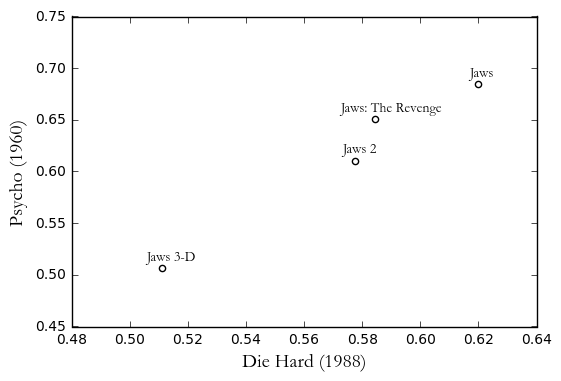

In [39]:
pd.DataFrame(list(zip(axis_1, axis_2))).plot(kind='scatter', x=0, y=1, c='w')

# Cause I'm lazy, you gotta fiddle with the values to get the titles to show up in the right spots.

for label, (x, y) in zip(list(titles.values), avoid_overlap(axis_1, 
                                                      axis_2, 
                                                      y_tolerance = 0.0006,
                                                      increment = 0.00002,
                                                     x_tolerance = 1)):
    label = label[:label.find('(')-1]
    plt.annotate(label,
                 fontsize=10,
                 fontname='Garamond',
                xy=(x - (len(label)*0.0007), y + 0.0075))
plt.xlabel(axis_1_title, fontname='Garamond', fontsize = 14)
plt.ylabel(axis_2_title, fontname='Garamond', fontsize = 14)  
plt.show()